# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier

sns.set_style('darkgrid')

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# load dataset
df = spark.read.json('mini_sparkify_event_data.json')
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [4]:
# Check data schema
print('- Schema:')
df.printSchema()

# Number of records
print('- Number of records:', df.count())

- Schema:
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

- Number of records: 286500


In [5]:
# convert to pandas for overview data
df_pandas = df.toPandas()

In [6]:
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [7]:
df_pandas.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   artist         228108 non-null  object 
 1   auth           286500 non-null  object 
 2   firstName      278154 non-null  object 
 3   gender         278154 non-null  object 
 4   itemInSession  286500 non-null  int64  
 5   lastName       278154 non-null  object 
 6   length         228108 non-null  float64
 7   level          286500 non-null  object 
 8   location       278154 non-null  object 
 9   method         286500 non-null  object 
 10  page           286500 non-null  object 
 11  registration   278154 non-null  float64
 12  sessionId      286500 non-null  int64  
 13  song           228108 non-null  object 
 14  status         286500 non-null  int64  
 15  ts             286500 non-null  int64  
 16  userAgent      278154 non-null  object 
 17  userId         286500 non-nul

In [8]:
df_pandas.describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [9]:
# check 'auth' values
df_pandas['auth'].value_counts()

Logged In     278102
Logged Out      8249
Guest             97
Cancelled         52
Name: auth, dtype: int64

In [10]:
# check 'level' values
df_pandas['level'].value_counts()

paid    228162
free     58338
Name: level, dtype: int64

In [11]:
# check 'page' values
df_pandas['page'].value_counts()

NextSong                     228108
Home                          14457
Thumbs Up                     12551
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Login                          3241
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Help                           1726
Settings                       1514
About                           924
Upgrade                         499
Save Settings                   310
Error                           258
Submit Upgrade                  159
Submit Downgrade                 63
Cancel                           52
Cancellation Confirmation        52
Register                         18
Submit Registration               5
Name: page, dtype: int64

In [12]:
# check 'status' values
df_pandas['status'].value_counts()

200    259812
307     26430
404       258
Name: status, dtype: int64

In [13]:
# check number of unique user
len(pd.unique(df_pandas['userId']))

226

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
# We will only use the following columns for the model: auth, gender, page, level, sessionId, ts, userId
# We will temporarily keep the following columns for filtering: status
df_clean = df.select(\
    'auth',\
    'gender',\
    'page',\
    'level',\
    'sessionId',\
    'ts',\
    'userId',\
    'status')

df_clean.show(5)

+---------+------+--------+-----+---------+-------------+------+------+
|     auth|gender|    page|level|sessionId|           ts|userId|status|
+---------+------+--------+-----+---------+-------------+------+------+
|Logged In|     M|NextSong| paid|       29|1538352117000|    30|   200|
|Logged In|     M|NextSong| free|        8|1538352180000|     9|   200|
|Logged In|     M|NextSong| paid|       29|1538352394000|    30|   200|
|Logged In|     M|NextSong| free|        8|1538352416000|     9|   200|
|Logged In|     M|NextSong| paid|       29|1538352676000|    30|   200|
+---------+------+--------+-----+---------+-------------+------+------+
only showing top 5 rows



In [15]:
# check null or empty values in dataframe 
df_clean.select([F.count(F.when((F.col(c).isNull()) | (F.col(c) == ''), c))
                 .alias(c) for c in df_clean.columns]
               ).show()

+----+------+----+-----+---------+---+------+------+
|auth|gender|page|level|sessionId| ts|userId|status|
+----+------+----+-----+---------+---+------+------+
|   0|  8346|   0|    0|        0|  0|  8346|     0|
+----+------+----+-----+---------+---+------+------+



There are **8346/286500** empty or null userID (~2.9%).

In [16]:
# check invalid or missing values due to not having userids
unknown_user = df_clean.filter((df_clean.userId.isNull()) | (df_clean.userId == ''))
unknown_user.show(5)

+----------+------+-----+-----+---------+-------------+------+------+
|      auth|gender| page|level|sessionId|           ts|userId|status|
+----------+------+-----+-----+---------+-------------+------+------+
|Logged Out|  null| Home| free|        8|1538355745000|      |   200|
|Logged Out|  null| Help| free|        8|1538355807000|      |   200|
|Logged Out|  null| Home| free|        8|1538355841000|      |   200|
|Logged Out|  null|Login| free|        8|1538355842000|      |   307|
|Logged Out|  null| Home| free|      240|1538356678000|      |   200|
+----------+------+-----+-----+---------+-------------+------+------+
only showing top 5 rows



In [17]:
# check 'page' values of unknown users
unknown_user.select('page').distinct().collect()

[Row(page='Home'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Help'),
 Row(page='Error')]

In [18]:
# check 'auth' values of unknown users
unknown_user.select('auth').distinct().collect()

[Row(auth='Logged Out'), Row(auth='Guest')]

We can see the result above shows that all unknown users logged out their accounts from the application or used it as guest. Hence, we received no identity of those cases. In this situation, we can go ahead to filter out all unknown users as there are no relevant information for predicting churn of users

In [19]:
# keep only the valid userids
df_clean = df_clean.filter(~((df_clean.userId.isNull()) | (df_clean.userId == '')))
df_clean.show(5)

+---------+------+--------+-----+---------+-------------+------+------+
|     auth|gender|    page|level|sessionId|           ts|userId|status|
+---------+------+--------+-----+---------+-------------+------+------+
|Logged In|     M|NextSong| paid|       29|1538352117000|    30|   200|
|Logged In|     M|NextSong| free|        8|1538352180000|     9|   200|
|Logged In|     M|NextSong| paid|       29|1538352394000|    30|   200|
|Logged In|     M|NextSong| free|        8|1538352416000|     9|   200|
|Logged In|     M|NextSong| paid|       29|1538352676000|    30|   200|
+---------+------+--------+-----+---------+-------------+------+------+
only showing top 5 rows



In [20]:
# check the status value to see whether there are status != 200
df_clean.select('status').distinct().collect()

[Row(status=307), Row(status=404), Row(status=200)]

In [21]:
# the status 404 indicates an error so it should be removed in the dataframe
df_clean = df_clean.filter(df.status != 404)

In [22]:
# convert 'ts' column to datetime
df_clean = df_clean.withColumn('ts', F.to_timestamp(F.col('ts')/1000))
df_clean.show(5)

+---------+------+--------+-----+---------+-------------------+------+------+
|     auth|gender|    page|level|sessionId|                 ts|userId|status|
+---------+------+--------+-----+---------+-------------------+------+------+
|Logged In|     M|NextSong| paid|       29|2018-10-01 07:01:57|    30|   200|
|Logged In|     M|NextSong| free|        8|2018-10-01 07:03:00|     9|   200|
|Logged In|     M|NextSong| paid|       29|2018-10-01 07:06:34|    30|   200|
|Logged In|     M|NextSong| free|        8|2018-10-01 07:06:56|     9|   200|
|Logged In|     M|NextSong| paid|       29|2018-10-01 07:11:16|    30|   200|
+---------+------+--------+-----+---------+-------------------+------+------+
only showing top 5 rows



In [23]:
# extract year, month, day from 'ts' column
df_clean = df_clean.withColumn('year', F.year('ts')) \
    .withColumn('month', F.month('ts')) \
    .withColumn('day', F.dayofmonth('ts')) \

df_clean.show(5)

+---------+------+--------+-----+---------+-------------------+------+------+----+-----+---+
|     auth|gender|    page|level|sessionId|                 ts|userId|status|year|month|day|
+---------+------+--------+-----+---------+-------------------+------+------+----+-----+---+
|Logged In|     M|NextSong| paid|       29|2018-10-01 07:01:57|    30|   200|2018|   10|  1|
|Logged In|     M|NextSong| free|        8|2018-10-01 07:03:00|     9|   200|2018|   10|  1|
|Logged In|     M|NextSong| paid|       29|2018-10-01 07:06:34|    30|   200|2018|   10|  1|
|Logged In|     M|NextSong| free|        8|2018-10-01 07:06:56|     9|   200|2018|   10|  1|
|Logged In|     M|NextSong| paid|       29|2018-10-01 07:11:16|    30|   200|2018|   10|  1|
+---------+------+--------+-----+---------+-------------------+------+------+----+-----+---+
only showing top 5 rows



In [24]:
# number of records
df_clean.count()

277902

#### Preliminary analysis

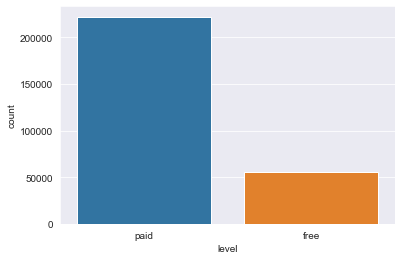

In [25]:
# show number of paid/free
pd_level = df_clean.select('level').toPandas()
sns.countplot('level', data=pd_level)

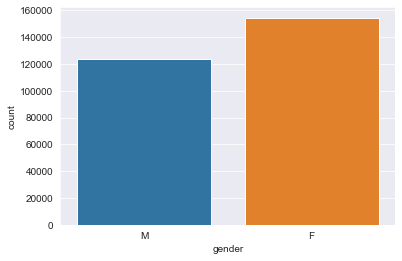

In [26]:
# show number of male/female
pd_gender = df_clean.select('gender').toPandas()
sns.countplot('gender', data=pd_gender)

#### Define Churn

In [27]:
# define churn by using the 'Cancellation Confirmation' events in 'page' column 
df_clean = df_clean.withColumn(
    "churn",
    F.when(F.col("page") == "Cancellation Confirmation", 1).otherwise(0)
)

df_clean.show(5)

+---------+------+--------+-----+---------+-------------------+------+------+----+-----+---+-----+
|     auth|gender|    page|level|sessionId|                 ts|userId|status|year|month|day|churn|
+---------+------+--------+-----+---------+-------------------+------+------+----+-----+---+-----+
|Logged In|     M|NextSong| paid|       29|2018-10-01 07:01:57|    30|   200|2018|   10|  1|    0|
|Logged In|     M|NextSong| free|        8|2018-10-01 07:03:00|     9|   200|2018|   10|  1|    0|
|Logged In|     M|NextSong| paid|       29|2018-10-01 07:06:34|    30|   200|2018|   10|  1|    0|
|Logged In|     M|NextSong| free|        8|2018-10-01 07:06:56|     9|   200|2018|   10|  1|    0|
|Logged In|     M|NextSong| paid|       29|2018-10-01 07:11:16|    30|   200|2018|   10|  1|    0|
+---------+------+--------+-----+---------+-------------------+------+------+----+-----+---+-----+
only showing top 5 rows



In [28]:
# number of churn users
df_clean.groupby('churn').count().show()

+-----+------+
|churn| count|
+-----+------+
|    1|    52|
|    0|277850|
+-----+------+



In [29]:
# calculate the churn rate
total_user = df_clean.select('userid').distinct().count()
churn_rate = 52/total_user*100 
print('Churn rate: %.2f%%' % churn_rate)

Churn rate: 23.11%


#### Explore Data

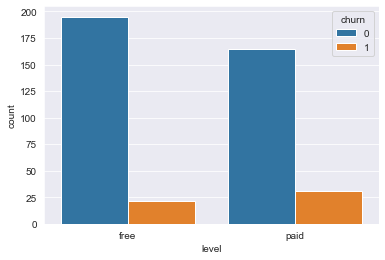

In [30]:
df_level = df_clean.select('userId', 'level', 'churn').distinct()
pd_level_churn = df_level.select('level', 'churn').toPandas()
sns.countplot(x='level', hue='churn', data=pd_level_churn);

From the bar chart above, we can obviously see whether a free user tend to cancel their account when comparing to the paid one. And it shows that there is a larger amount of users who paid for the app decided to cancel the app. 

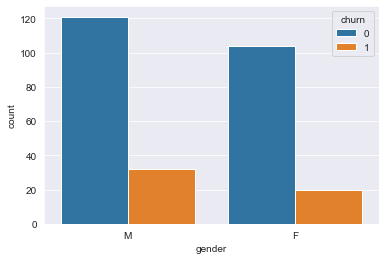

In [31]:
df_gender = df_clean.select('userId', 'gender', 'churn').distinct()
pd_gender_churn = df_gender.select('gender', 'churn').toPandas()
sns.countplot(x='gender', hue='churn', data=pd_gender_churn);

This second bar chart shows us that male users seems to be more active to use this app than female users are. It somehow has the same tendency with the ratio of canceling the app between the male and female users. We can see that the number of churn male users is nearly twice as many as the one of churn female user.

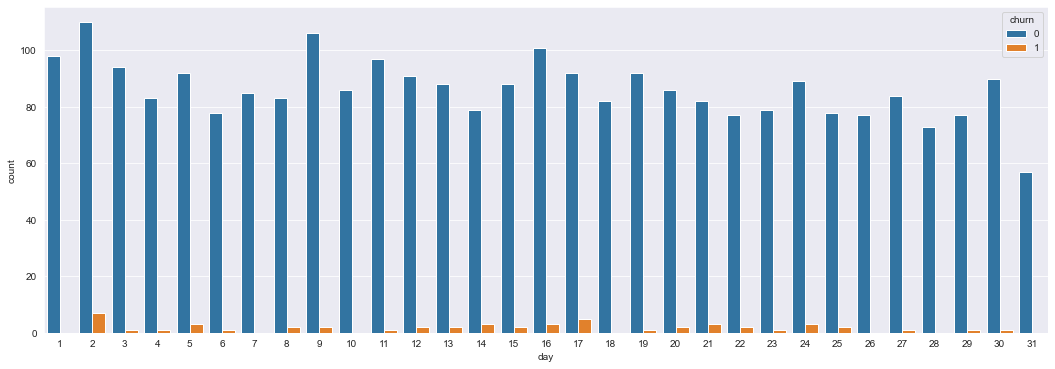

In [32]:
df_user_session = df_clean.select('userId', 'day', 'churn').distinct()
pd_user_session_churn = df_user_session.select('day', 'churn').toPandas()
plt.figure(figsize=(18,6))
sns.countplot(x='day', hue='churn', data=pd_user_session_churn);

This bar chart shows the interaction of the users through days in a month. And there are some days in a month we had many users who decided to cancel the application such as: 2nd, 12th, 17th, 20th of a month.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Features selected for building model:

- churn (Label)
- level
- gender
- daily_session
- monthly_session
- daily_interaction
- monthly_interaction

In [33]:
df_clean.show(5)

+---------+------+--------+-----+---------+-------------------+------+------+----+-----+---+-----+
|     auth|gender|    page|level|sessionId|                 ts|userId|status|year|month|day|churn|
+---------+------+--------+-----+---------+-------------------+------+------+----+-----+---+-----+
|Logged In|     M|NextSong| paid|       29|2018-10-01 07:01:57|    30|   200|2018|   10|  1|    0|
|Logged In|     M|NextSong| free|        8|2018-10-01 07:03:00|     9|   200|2018|   10|  1|    0|
|Logged In|     M|NextSong| paid|       29|2018-10-01 07:06:34|    30|   200|2018|   10|  1|    0|
|Logged In|     M|NextSong| free|        8|2018-10-01 07:06:56|     9|   200|2018|   10|  1|    0|
|Logged In|     M|NextSong| paid|       29|2018-10-01 07:11:16|    30|   200|2018|   10|  1|    0|
+---------+------+--------+-----+---------+-------------------+------+------+----+-----+---+-----+
only showing top 5 rows



In [34]:
# show the first date and the last date of recorded data
df_clean.agg(F.min("ts"), F.max("ts")).show()

+-------------------+-------------------+
|            min(ts)|            max(ts)|
+-------------------+-------------------+
|2018-10-01 07:01:57|2018-12-03 08:11:16|
+-------------------+-------------------+



In [35]:
# show months
df_clean.select('month').distinct().collect()

[Row(month=12), Row(month=10), Row(month=11)]

In [36]:
# show days
df_clean.select('day').distinct().collect()

[Row(day=31),
 Row(day=28),
 Row(day=26),
 Row(day=27),
 Row(day=12),
 Row(day=22),
 Row(day=1),
 Row(day=13),
 Row(day=6),
 Row(day=16),
 Row(day=3),
 Row(day=20),
 Row(day=5),
 Row(day=19),
 Row(day=15),
 Row(day=9),
 Row(day=17),
 Row(day=4),
 Row(day=8),
 Row(day=23),
 Row(day=7),
 Row(day=10),
 Row(day=25),
 Row(day=24),
 Row(day=29),
 Row(day=21),
 Row(day=11),
 Row(day=14),
 Row(day=2),
 Row(day=30),
 Row(day=18)]

In [37]:
# daily session per user - df
daily_session_per_user = df_clean.groupBy('userId', 'day').agg(
    F.count('sessionId').alias('daily_session')
)
# average daily session
daily_session_per_user = daily_session_per_user.groupBy('userId').agg(
    F.avg('daily_session').alias('avg_daily_session')
)

# monthly session per user - df
monthly_session_per_user = df_clean.groupBy('userId', 'month').agg(
    F.count('sessionId').alias('monthly_session')
)
# average monthly session
monthly_session_per_user = monthly_session_per_user.groupBy('userId').agg(
    F.avg('monthly_session').alias('avg_monthly_session')
)

In [38]:
# join data for session df
session_per_user = daily_session_per_user.join(monthly_session_per_user, 'userId', 'full')
session_per_user = session_per_user.select(
    'userId',
    'avg_daily_session',
    'avg_monthly_session'
)

In [39]:
session_per_user.show(10)

+------+------------------+-------------------+
|userId| avg_daily_session|avg_monthly_session|
+------+------------------+-------------------+
|100010|            47.625|              190.5|
|200002| 67.71428571428571|              237.0|
|   125|              11.0|               11.0|
|   124|185.34615384615384|             2409.5|
|    51|            205.25|             2463.0|
|     7|28.571428571428573|              100.0|
|    15|133.88235294117646|             1138.0|
|    54|143.16666666666666|             1718.0|
|   155|142.71428571428572|              999.0|
|100014|             38.75|              155.0|
+------+------------------+-------------------+
only showing top 10 rows



In [40]:
# daily item per user - df
daily_item_per_user = df_clean.groupBy('userId', 'day').agg(
    F.countDistinct('page').alias('daily_item')
)
# average daily item
daily_item_per_user = daily_item_per_user.groupBy('userId').agg(
    F.avg('daily_item').alias('avg_daily_item')
)

# monthly item per user - df
monthly_item_per_user = df_clean.groupBy('userId', 'month').agg(
    F.countDistinct('page').alias('monthly_item')
)
# average monthly item
monthly_item_per_user = monthly_item_per_user.groupBy('userId').agg(
    F.avg('monthly_item').alias('avg_monthly_item')
)

In [41]:
# join data for item df
item_per_user = daily_item_per_user.join(monthly_item_per_user, 'userId', 'full')
item_per_user = item_per_user.select(
    'userId',
    'avg_daily_item',
    'avg_monthly_item'
)

In [42]:
item_per_user.show(10)

+------+-----------------+----------------+
|userId|   avg_daily_item|avg_monthly_item|
+------+-----------------+----------------+
|100010|              6.0|            10.5|
|200002|6.857142857142857|            11.0|
|   125|              4.0|             4.0|
|   124|7.769230769230769|            12.5|
|    51|              8.5|            14.0|
|     7|4.857142857142857|             9.5|
|    15|7.764705882352941|            12.5|
|    54|8.083333333333334|            15.0|
|   155|8.285714285714286|            14.0|
|100014|            5.125|            10.0|
+------+-----------------+----------------+
only showing top 10 rows



In [43]:
# final dataframe
final_df = session_per_user.join(item_per_user, 'userId', 'full')
final_df = final_df.select(
    'userId',
    'avg_daily_session',
    'avg_monthly_session',
    'avg_daily_item',
    'avg_monthly_item'
)

In [44]:
# join df_clean to get all needed features
final_df = final_df.join(df_clean, 'userId', 'left')
final_df = final_df.select(
    'userId',
    'gender',
    'level',
    'avg_daily_session',
    'avg_monthly_session',
    'avg_daily_item',
    'avg_monthly_item',
    'churn'
).dropDuplicates()

In [45]:
# with the same userID: the churn value '1' should be kept 
final_df = final_df.withColumn('sum_churn', F.sum('churn').over(Window.partitionBy('userId')))
final_df = final_df.filter(~((F.col('churn') == 0) & (F.col('sum_churn') > 0)))

In [46]:
final_df.show(10)

+------+------+-----+------------------+-------------------+-----------------+----------------+-----+---------+
|userId|gender|level| avg_daily_session|avg_monthly_session|   avg_daily_item|avg_monthly_item|churn|sum_churn|
+------+------+-----+------------------+-------------------+-----------------+----------------+-----+---------+
|100010|     F| free|            47.625|              190.5|              6.0|            10.5|    0|        0|
|200002|     M| free| 67.71428571428571|              237.0|6.857142857142857|            11.0|    0|        0|
|200002|     M| paid| 67.71428571428571|              237.0|6.857142857142857|            11.0|    0|        0|
|   125|     M| free|              11.0|               11.0|              4.0|             4.0|    1|        1|
|   124|     F| paid|185.34615384615384|             2409.5|7.769230769230769|            12.5|    0|        0|
|    51|     M| paid|            205.25|             2463.0|              8.5|            14.0|    1|   

In [47]:
final_df.groupby('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  278|
+-----+-----+



In [48]:
# there are some users who first used the app free and then they paid for it.
# we can consider those users as the paid users and drop the free-using records of them
final_df = final_df.withColumn('level', F.when(F.col('level') == 'paid', 1).otherwise(0))
final_df = final_df.withColumn('is_paid', F.sum('level').over(Window.partitionBy('userId')))
final_df = final_df.filter(~((F.col('level') == 0) & (F.col('is_paid') > 0)))

In [49]:
# convert 'gender' column to numeric value (M:1, F:0)
final_df = final_df.withColumn('gender', F.when(F.col('gender') == 'M', 1).otherwise(0))

In [50]:
# select needed column for final df
final_df = final_df.select(
    'userId',
    'gender',
    'level',
    'avg_daily_session',
    'avg_monthly_session',
    'avg_daily_item',
    'avg_monthly_item',
    'churn'
)

In [51]:
final_df.show(10)

+------+------+-----+------------------+-------------------+-----------------+----------------+-----+
|userId|gender|level| avg_daily_session|avg_monthly_session|   avg_daily_item|avg_monthly_item|churn|
+------+------+-----+------------------+-------------------+-----------------+----------------+-----+
|100010|     0|    0|            47.625|              190.5|              6.0|            10.5|    0|
|200002|     1|    1| 67.71428571428571|              237.0|6.857142857142857|            11.0|    0|
|   125|     1|    0|              11.0|               11.0|              4.0|             4.0|    1|
|   124|     0|    1|185.34615384615384|             2409.5|7.769230769230769|            12.5|    0|
|    51|     1|    1|            205.25|             2463.0|              8.5|            14.0|    1|
|     7|     1|    0|28.571428571428573|              100.0|4.857142857142857|             9.5|    0|
|    15|     1|    1|133.88235294117646|             1138.0|7.764705882352941|    

In [52]:
final_df.count()

225

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [53]:
# get feature columns
feature_col = final_df.columns[1:-1]
feature_col

['gender',
 'level',
 'avg_daily_session',
 'avg_monthly_session',
 'avg_daily_item',
 'avg_monthly_item']

In [54]:
# Split dataset into train, test data
train_data, test_data = final_df.randomSplit([0.8, 0.2])

In [55]:
# function to build model
def build_model(clf, param):
    '''
    Build the classfication model with Cross Validation
    
    clf: classification model
    param: parameter tuning for the model
    
    return: built classfication model
    '''
    
    assembler = VectorAssembler(inputCols=feature_col, outputCol='features')
    scaler = MinMaxScaler(inputCol='features', outputCol='mmScale_features')
    pipeline = Pipeline(stages=[assembler, scaler, clf])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=5,
    )
    return model

# function to evaluate the built model
def evaluate_model(churn_pred):
    ''' Model evaluation with F1 score metric '''
    
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='churn')
    f1_score = evaluator.evaluate(churn_pred, {evaluator.metricName: 'f1'})
    print('F1 score: ', f1_score)

In [56]:
# Logistic Regression model
lr = LogisticRegression(featuresCol='mmScale_features', labelCol='churn')
lr_param = ParamGridBuilder().build()
lr_model = build_model(lr, lr_param)
# fit model 
lr_model = lr_model.fit(train_data)
churn_pred_lr = lr_model.transform(test_data)
# evaluate model
evaluate_model(churn_pred_lr)

F1 score:  0.9007637242931361


In [57]:
# Random Forest model
rf = RandomForestClassifier(featuresCol='mmScale_features', labelCol='churn')
rf_param = ParamGridBuilder().build()
rf_model = build_model(rf, rf_param)
# fit model 
rf_model = rf_model.fit(train_data)
churn_pred_rf = rf_model.transform(test_data)
# evaluate model
evaluate_model(churn_pred_rf)

F1 score:  0.8452674897119341


In [58]:
# Gradient Boosting model
gb = GBTClassifier(featuresCol='mmScale_features', labelCol='churn')
gb_param = ParamGridBuilder().build()
gb_model = build_model(gb, gb_param)
# fit model 
gb_model = gb_model.fit(train_data)
churn_pred_gb = gb_model.transform(test_data)
# evaluate model
evaluate_model(churn_pred_gb)

F1 score:  0.8210790071255187


In [59]:
# apply hyperparameter to find the best parameter for model
gb_param_new = ParamGridBuilder() \
    .addGrid(gb.maxDepth, [3, 5, 7]) \
    .build()
gb_model_new = build_model(gb, gb_param_new)
# fit model 
gb_model_new = gb_model_new.fit(train_data)
churn_pred_gb_new = gb_model_new.transform(test_data)
# evaluate model
evaluate_model(churn_pred_gb_new)

F1 score:  0.888888888888889


In [60]:
# extract the best max depth applied for the model
best_model = gb_model_new.bestModel
print('The best parameter for maxDepth:', best_model.stages[2].getOrDefault('maxDepth'))

The best parameter for maxDepth: 3


In [61]:
# Extract important features
for i in range(len(best_model.stages[2].featureImportances)):
    print('{} : {} \n'.format(final_df.columns[i], best_model.stages[2].featureImportances[i]))

userId : 0.005301542479173895 

gender : 0.018047505349156952 

level : 0.22080577718792696 

avg_daily_session : 0.1797104088859551 

avg_monthly_session : 0.27404281333677766 

avg_daily_item : 0.30209195276100953 



# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

